In [1]:
import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
import pdb
#import ipdb
import h5py
import importlib
import pickle
import math
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import axes3d    

# Add root folder to sys path
sys.path.append("../")

from load_expert_traj import recursively_save_dict_contents_to_group

# %pylab inline
# inline doesn't give interactive plots
%matplotlib inline 
# %matplotlib notebook
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

sns.set()

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2

# Import own modules
# Need to use importlib since module starts with a numerical value.

PCA state variance [ 0.66953069  0.26160362]
PCA action variance [ 0.53357691  0.26275608]
Context length: 2919
Context length: 707
Context length: 574
Context length: 280
Context length: 515
Context length: 2919
Context length: 707
Context length: 574
Context length: 280
Context length: 515


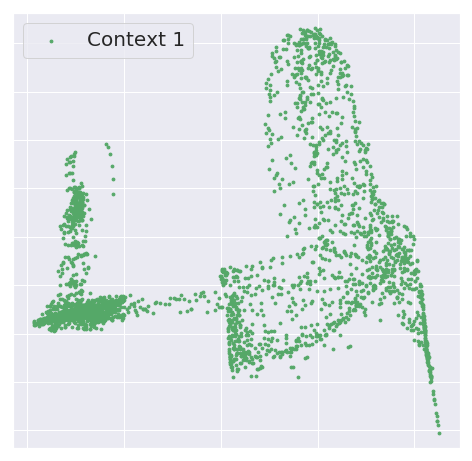

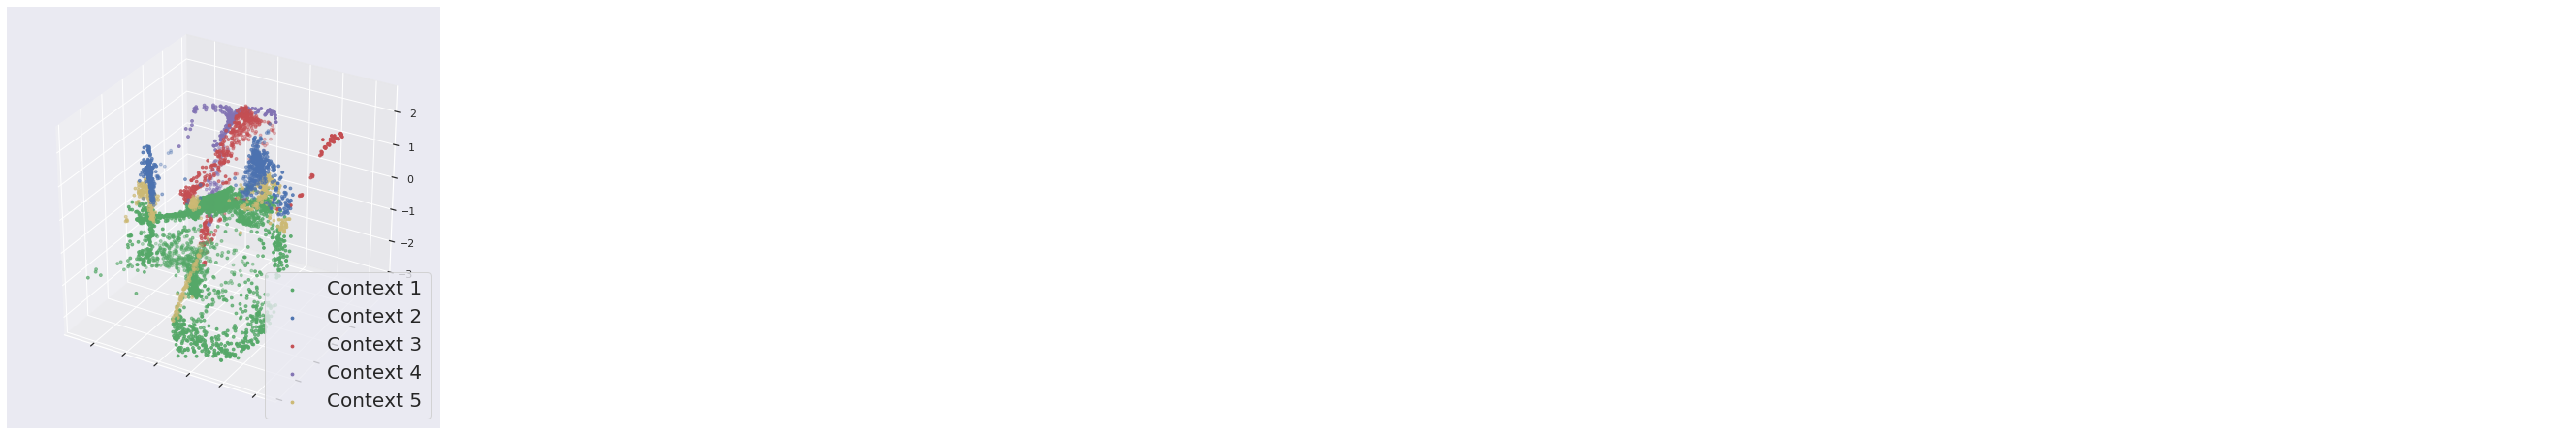

PCA state variance [ 0.66039288  0.27218682]
PCA action variance [ 0.53569049  0.26321647]
Context length: 604
Context length: 861
Context length: 1478
Context length: 2052
Context length: 604
Context length: 861
Context length: 1478
Context length: 2052


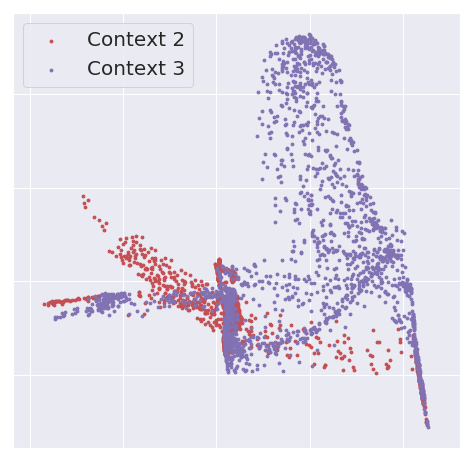

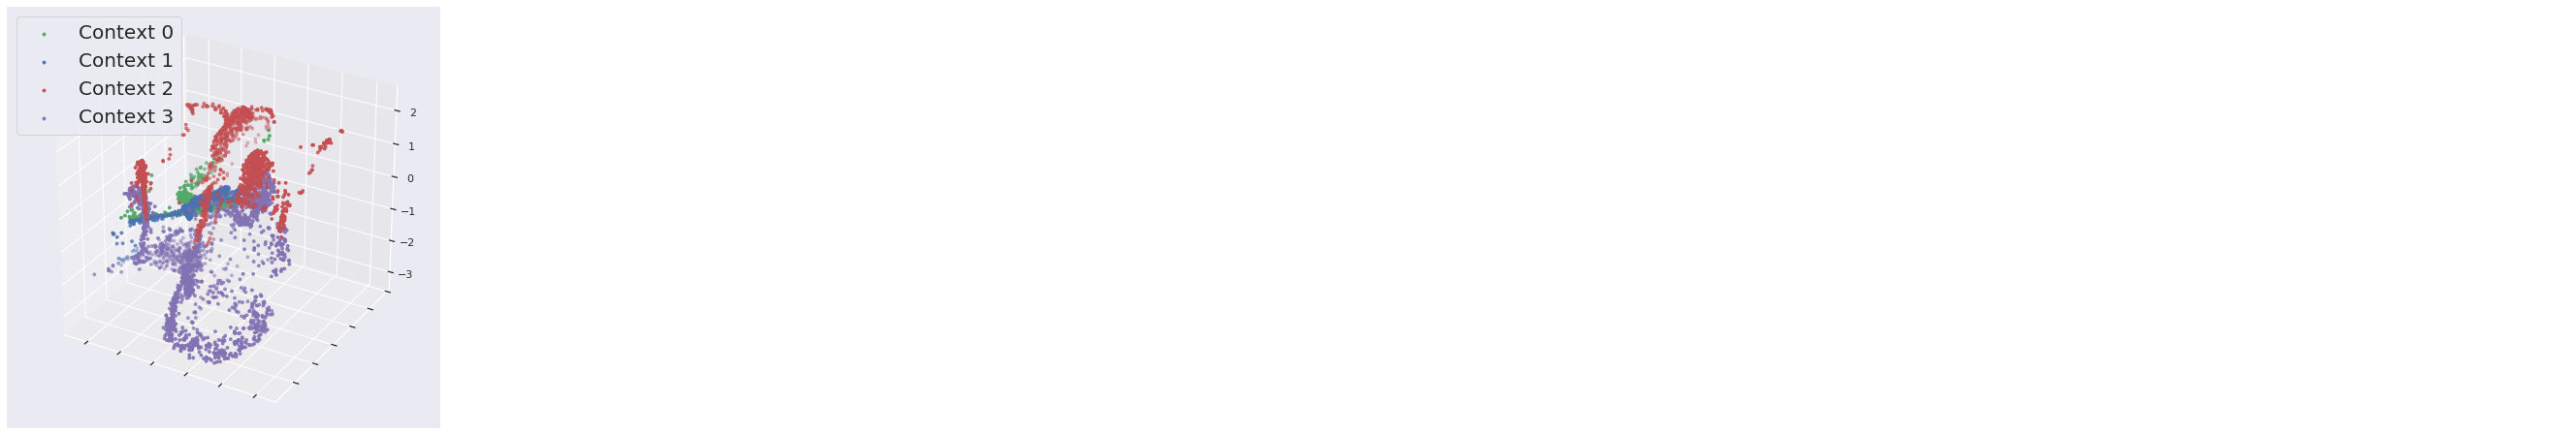

In [3]:
def plot_pca_hopper(pkl_path, save_path=None):
    with open(pkl_path, 'rb') as pkl_f:
        results_data = pickle.load(pkl_f)
    
    state_list, action_list, context_list = [], [], []
    for i in range(len(results_data['pred_traj_state'])):
        pred_traj = results_data['pred_traj_state'][i]
        pred_action = results_data['pred_traj_action'][i]
        traj_context = np.argmax(results_data['pred_context'][i].squeeze(), axis=1)
    
        state_list.append(pred_traj)
        action_list.append(pred_action)
        context_list.append(traj_context)
    
    state_array = np.array(state_list)
    action_array = np.array(action_list)
    state_array = np.reshape(state_array, 
                             (state_array.shape[0]*state_array.shape[1], state_array.shape[2]))
    action_array = action_array.reshape(-1, action_array.shape[2])
    context_array = np.array(context_list)
    context_array = np.reshape(context_array, 
                               (context_array.shape[0]*context_array.shape[1],))

    pca = PCA(n_components=2)
    pca.fit(state_array)
    pca_actions = PCA(n_components=2)
    pca_actions.fit(action_array)
    
    print("PCA state variance {}".format(pca.explained_variance_ratio_))
    print("PCA action variance {}".format(pca_actions.explained_variance_ratio_))
    state_transformed = pca.fit_transform(state_array)
    action_transformed = pca_actions.fit_transform(action_array)
    action_transformed = action_array
    
    context_array = context_array.astype(np.int32)

    fig = plt.figure(figsize=(8.0,8.0))
    ax = fig.add_subplot(111)
    
    context_colors = ['g', 'b', 'r', 'm', 'y', 'c', 'k', 'w']
    all_context_list = np.unique(context_array).tolist()
    for i in range(len(all_context_list)):
        data = state_transformed[context_array == all_context_list[i], :]
        print("Context length: {}".format(data.shape[0]))
        if data.shape[0] < 1000:
            continue
        ax.scatter(
            data[:, 0],
            data[:, 1],
            color=context_colors[i],
            label='Context {}'.format(all_context_list[i]),
            s=8)

    ax.axis('equal')   
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.legend(prop={'size': 20})
    
    fig = plt.figure(figsize=(8.0,8.0))
    ax = fig.add_subplot(111, projection='3d')
    # Plot PCA for actions
    for i in range(len(all_context_list)):
        data = action_transformed[context_array == all_context_list[i], :]
        print("Context length: {}".format(data.shape[0]))
        ax.scatter(
            data[:, 0],
            data[:, 1],
            data[:, 2],
            color=context_colors[i],
            label='Context {}'.format(all_context_list[i]),
            s=8)

    ax.axis('equal')   
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.legend(prop={'size': 20})

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

def plot_pca_walker(pkl_path):
    with open(pkl_path, 'rb') as pkl_f:
        results_data = pickle.load(pkl_f)
    save_data_path = '../mujoco_results/'
    
    state_list, context_list = [], []

    for i in range(len(results_data['pred_traj_state'])):
        pred_traj = results_data['pred_traj_state'][i]
        traj_context = np.argmax(results_data['pred_context'][i].squeeze(), axis=1)
    
        state_list.append(pred_traj)
        context_list.append(traj_context)
    
    state_array = np.array(state_list)
    state_array = np.reshape(state_array, (-1, state_array.shape[2]))
    context_array = np.array(context_list).reshape((-1))

    pca = PCA(n_components=3)
    pca.fit(state_array)

    print(pca.explained_variance_ratio_)
    state_transformed = pca.fit_transform(state_array)
    
    context_array = context_array.astype(np.int32)

    fig = plt.figure(figsize=(8.0,8.0))
    ax = fig.add_subplot(111, projection='3d')
    context_colors = ['g', 'b', 'r', 'm', 'y', 'c', 'k', 'w']
    all_context_list = np.unique(context_array).tolist()
    for i in range(len(all_context_list)):
        data = state_transformed[context_array == all_context_list[i], :]
        ax.scatter(
            data[:, 0],
            data[:, 1],
            data[:, 2],
            color=context_colors[i],
            label='Context {}'.format(all_context_list[i]),
            s=8)

    ax.axis('equal')   
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.legend(prop={'size': 20})

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    

#pkl_path = '../results/hopper/discrete_vae/batch_64_context_4_no_time/results/results_cp_640.pkl'
# save_path = '../mujoco_results/pca_hopper_expert.pdf'

pkl_path = '../results/walker_2d/discrete_vae/expert_trajs_100/batch_64_context_3_no_time/results/results_cp_1000.pkl'
save_path = '../mujoco_results/pca_walker_expert.pdf'

plot_pca_hopper('../results/hopper/discrete_vae/batch_64_context_8_no_time_init_temp_5.0/results_2000.pkl')
plot_pca_hopper('../results/hopper/discrete_vae/batch_64_context_4_no_time_init_temp_5.0/results_2000.pkl')
# plot_pca_hopper('../results/hopper/discrete_vae/batch_64_context_8_no_time/results_expert_cp_800.pkl')
#plot_pca_hopper('../results/hopper/discrete_vae/batch_64_context_8_no_time_try_2/results_expert_cp_2000.pkl',
#                None)
# plot_pca_walker('../results/walker/vae/batch_64_context_4_no_time/results/results_cp_1000.pkl')